# CSC311 Assignment 3

# Author: Anlan Wu (utorid: wuanlan)

## Question 1 Code

Average log-likelihood for MLE is  2.0621952281275656e-05
Average log-likelihood for MAP is  2.0616846643288375e-05
Training accuracy for MAP is  0.016853703741420395
Test accuracy for MAP is  0.035282898919262555


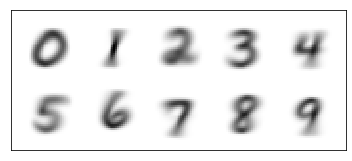

In [292]:
# %load naive_bayes.py
from __future__ import absolute_import
from __future__ import print_function
from future.standard_library import install_aliases
install_aliases()
import numpy as np
import os
import gzip
import struct
import array
import matplotlib.pyplot as plt
import matplotlib.image
from urllib.request import urlretrieve


def download(url, filename):
    if not os.path.exists('data'):
        os.makedirs('data')
    out_file = os.path.join('data', filename)
    if not os.path.isfile(out_file):
        urlretrieve(url, out_file)


def mnist():
    base_url = 'http://yann.lecun.com/exdb/mnist/'

    def parse_labels(filename):
        with gzip.open(filename, 'rb') as fh:
            magic, num_data = struct.unpack(">II", fh.read(8))
            return np.array(array.array("B", fh.read()), dtype=np.uint8)

    def parse_images(filename):
        with gzip.open(filename, 'rb') as fh:
            magic, num_data, rows, cols = struct.unpack(">IIII", fh.read(16))
            return np.array(array.array("B", fh.read()), dtype=np.uint8).reshape(num_data, rows, cols)

    for filename in ['train-images-idx3-ubyte.gz',
                     'train-labels-idx1-ubyte.gz',
                     't10k-images-idx3-ubyte.gz',
                     't10k-labels-idx1-ubyte.gz']:
        download(base_url + filename, filename)

    train_images = parse_images('data/train-images-idx3-ubyte.gz')
    train_labels = parse_labels('data/train-labels-idx1-ubyte.gz')
    test_images = parse_images('data/t10k-images-idx3-ubyte.gz')
    test_labels = parse_labels('data/t10k-labels-idx1-ubyte.gz')

    return train_images, train_labels, test_images[:1000], test_labels[:1000]


def load_mnist():
    partial_flatten = lambda x: np.reshape(x, (x.shape[0], np.prod(x.shape[1:])))
    one_hot = lambda x, k: np.array(x[:, None] == np.arange(k)[None, :], dtype=int)
    train_images, train_labels, test_images, test_labels = mnist()
    train_images = (partial_flatten(train_images) / 255.0 > .5).astype(float)
    test_images = (partial_flatten(test_images) / 255.0 > .5).astype(float)
    train_labels = one_hot(train_labels, 10)
    test_labels = one_hot(test_labels, 10)
    N_data = train_images.shape[0]

    return N_data, train_images, train_labels, test_images, test_labels


def plot_images(images, ax, ims_per_row=5, padding=5, digit_dimensions=(28, 28),
                cmap=matplotlib.cm.binary, vmin=None, vmax=None):
    """Images should be a (N_images x pixels) matrix."""
    N_images = images.shape[0]
    N_rows = np.int32(np.ceil(float(N_images) / ims_per_row))
    pad_value = np.min(images.ravel())
    concat_images = np.full(((digit_dimensions[0] + padding) * N_rows + padding,
                             (digit_dimensions[1] + padding) * ims_per_row + padding), pad_value)
    for i in range(N_images):
        cur_image = np.reshape(images[i, :], digit_dimensions)
        row_ix = i // ims_per_row
        col_ix = i % ims_per_row
        row_start = padding + (padding + digit_dimensions[0]) * row_ix
        col_start = padding + (padding + digit_dimensions[1]) * col_ix
        concat_images[row_start: row_start + digit_dimensions[0],
                      col_start: col_start + digit_dimensions[1]] = cur_image
        cax = ax.matshow(concat_images, cmap=cmap, vmin=vmin, vmax=vmax)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
    return cax


def save_images(images, filename, **kwargs):
    fig = plt.figure(1)
    fig.clf()
    ax = fig.add_subplot(111)
    plot_images(images, ax, **kwargs)
    fig.patch.set_visible(False)
    ax.patch.set_visible(False)
    plt.savefig(filename)


def train_mle_estimator(train_images, train_labels):
    """ Inputs: train_images, train_labels
        Returns the MLE estimators theta_mle and pi_mle"""

    # YOU NEED TO WRITE THIS PART
    N_jc = np.dot(train_images.T,train_labels)
    N_c = np.sum(train_labels, axis=0)
    N = np.sum(N_c)
    
    theta_mle = np.divide(N_jc, N_c)
    pi_mle = N_c / N
    
    return theta_mle, pi_mle


def train_map_estimator(train_images, train_labels):
    """ Inputs: train_images, train_labels
        Returns the MAP estimators theta_map and pi_map"""
    
    # YOU NEED TO WRITE THIS PART
    
    # numerator is same as mle + a - 1
    # denominator is same as mle + a + b - 2
    N_jc = np.dot(train_images.T,train_labels) + 2
    N_c = np.sum(train_labels, axis=0) + 4
    N = np.sum(np.sum(train_labels, axis=0))
    
    theta_map = np.divide(N_jc, N_c)
    pi_map = np.sum(train_labels, axis=0) / N
    
    return theta_map, pi_map


def log_likelihood(images, theta, pi):
    """ Inputs: images, theta, pi
        Returns the matrix 'log_like' of loglikehoods over the input images where
    log_like[i,c] = log p (c |x^(i), theta, pi) using the estimators theta and pi.
    log_like is a matrix of num of images x num of classes
    Note that log likelihood is not only for c^(i), it is for all possible c's."""

    # YOU NEED TO WRITE THIS PART
    joint = np.log(pi) + np.log(np.dot(images, theta))
    log_like = joint / np.sum(joint, axis=0)

    return log_like


def predict(log_like):
    """ Inputs: matrix of log likelihoods
    Returns the predictions based on log likelihood values"""

    # YOU NEED TO WRITE THIS PART
    predictions = np.argmax(log_like, axis=1)
    
    return predictions


def accuracy(log_like, labels):
    """ Inputs: matrix of log likelihoods and 1-of-K labels
    Returns the accuracy based on predictions from log likelihood values"""

    # YOU NEED TO WRITE THIS PART
    predictions = predict(log_like)
    accuracy = np.sum(predictions == np.argmax(labels)) / np.sum(predictions)
    
    return accuracy


def image_sampler(theta, pi, num_images):
    """ Inputs: parameters theta and pi, and number of images to sample
    Returns the sampled images"""

    # YOU NEED TO WRITE THIS PART
    for i in range(num_images):
        p = np.random.choice(pi)
        np.random.binomial([i for i in range(10)], p)
    
    return sampled_images


def main():
    N_data, train_images, train_labels, test_images, test_labels = load_mnist()

    # Fit MLE and MAP estimators
    theta_mle, pi_mle = train_mle_estimator(train_images, train_labels)
    theta_map, pi_map = train_map_estimator(train_images, train_labels)

    # Find the log likelihood of each data point
    loglike_train_mle = log_likelihood(train_images, theta_mle, pi_mle)
    loglike_train_map = log_likelihood(train_images, theta_map, pi_map)

    avg_loglike_mle = np.sum(loglike_train_mle * train_labels) / N_data
    avg_loglike_map = np.sum(loglike_train_map * train_labels) / N_data

    print("Average log-likelihood for MLE is ", avg_loglike_mle)
    print("Average log-likelihood for MAP is ", avg_loglike_map)

    train_accuracy_map = accuracy(loglike_train_map, train_labels)
    loglike_test_map = log_likelihood(test_images, theta_map, pi_map)
    test_accuracy_map = accuracy(loglike_test_map, test_labels)

    print("Training accuracy for MAP is ", train_accuracy_map)
    print("Test accuracy for MAP is ", test_accuracy_map)

    # Plot MLE and MAP estimators
    save_images(theta_mle.T, 'mle.png')
    save_images(theta_map.T, 'map.png')

    # Sample 10 images
    #sampled_images = image_sampler(theta_map, pi_map, 10)
    #save_images(sampled_images, 'sampled_images.png')


if __name__ == '__main__':
    main()


## Question 1.a

$l(\theta) = \sum_{i=1}^N log(c^{(i)},x^{(i)})$

$= \sum_{i=1}^{N} log [p(c^{(i)}|\pi) \prod_{j=1}^{D} p(x_j^{(i)}|c^{(i)},\theta_{jc})]$

$= \sum_{i=1}^{N} log p(c^{(i)}|\pi) + \sum_{j=1}^{D}\sum_{i=1}^{N} log p(x_j^{(i)}|c^{(i)},\theta_{jc})$

For $\theta_{jc}$ can look at second term:

$\sum_{j=1}^{D}\sum_{i=1}^{N} log p(x_j^{(i)}|c^{(i)},\theta_{jc}) = \sum_{i=1}^{N} \sum_{c=0}^{9} t_c^{(i)} \{ x_j^{(i)} log \theta_{jc} + (1 - x_j^{(i)}) log(1 - \theta_{jc})\})$

Take partial derivative w.r.t. $\theta_{jc}$:

$\frac{\partial l(\theta)}{\partial \theta_{jc}} = \frac{\sum_{i=1}^{N} t_c^{(i)} x_j^{(i)}} {\theta_{jc}} - \frac{\sum_{i=1}^{N} t_c^{(i)} (1 - x_j^{(i)})}{1 - \theta_{jc}}$

For $j = 0,..,D$ and $c = 0,..,9$ we have (after setting derivative to 0 and solving for $\theta_{jc}$):

$\hat{\theta}_{jc} = \frac{\sum_{i=1}^{N}I[x_j^{(i)} = 1 \& t_c^{(i)} = 1]}{\sum_{i=1}^{N} I[t_c^{(i)} = 1]}$

$\hat{\theta}_{jc} =$ (number of images with feature j = 1 and class c) / (number of images with class c)

For $\pi_c$ we can look at the first term:

$\sum_{i=1}^{N} log p(c^{(i)}|\pi) = \sum_{i=1}^{N} \sum_{c=0}^{9} t_c^{(i)} log \pi_c + \sum_{i=1}^{N} \sum_{c=0}^{9} (1 - t_c^{(i)}) log(1 - \pi_c)$

Take partial derivative w.r.t. $\pi_{j}$:

$\frac{\partial l(\theta)}{\partial \pi_{j}} = \frac{\sum_{i=1}^{N} t_c^{(i)}} {\pi_{j}} - \frac{\sum_{i=1}^{N} (1 - t_c^{(i)})}{1 - \pi_{j}}$

For each $c = 0,..,9$ we have:

$\hat{\pi}_c = \frac{\sum_{i=1}^{N} I[t_c^{(i)} = 1]}{N}$

$\hat{\pi}_c =$ (number of images with class c) / (total number of images)

## Question 1.b 

Using Bayes Rule:

$log p(c|x,\theta,\pi) = log[\frac{p(x,c|\theta,\pi)}{p(x, \theta, \pi)}]$

$= log[\frac{p(c|\pi)\prod_{j=1}^D p(x_j|c, \theta_{jc})}{\sum_{c'} p(c') \prod_{j=1}^D p(x_j|c')}]$

$= log p(c|\pi)\prod_{j=1}^D p(x_j|c, \theta_{jc}) - log \sum_{c'} p(c') \prod_{j=1}^D p(x_j|c')$

$= log p(c|\pi) + \sum_{j=1}^D log p(x_j|c, \theta_{jc}) - log \sum_{c'} p(c') + \sum_{j=1}^D log p(x_j|c')$

## Question 1.c

See  Question 1 Code above.

## Question 1.d 

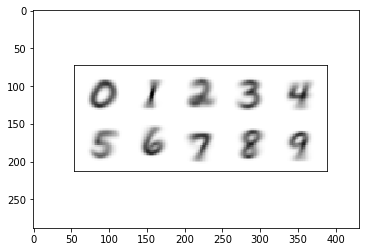

In [282]:
mle_image = matplotlib.image.imread('mle.png')
imgplot = plt.imshow(mle_image)
plt.show()

## Question 1.f 

See Question 1 Code above.

## Question 1.g 

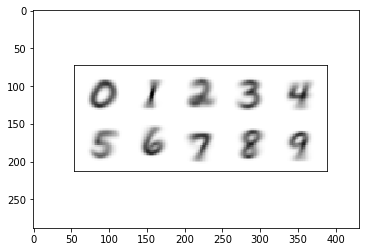

In [283]:
map_image = matplotlib.image.imread('map.png')
imgplot = plt.imshow(mle_image)
plt.show()

## Question 2.a

True. Any two pixels $x_i$ and $x_j$ where $i \neq j$ are independent given $c$. This comes from the naive assumption we use in the Naive Bayes model where we assume the pixels are conditionally independent given the class $c$.

## Question 2.b

False. Knowing the class $c$ affects the probability of a given pixel $x_i$ being 1 if we know $x_j$ (where $i \neq j$). We can no longer assume the pixels are independent.

## Question 2.c

See above in section Question 1 code.

## Question 3 Code

In [160]:
import numpy as np

def load_data(filename, load2=True, load3=True):
  """Loads data for 2's and 3's
  Inputs:
    filename: Name of the file.
    load2: If True, load data for 2's.
    load3: If True, load data for 3's.
  """
  assert (load2 or load3), "Atleast one dataset must be loaded."
  data = np.load(filename)
  if load2 and load3:
    inputs_train = np.hstack((data['train2'], data['train3']))
    inputs_valid = np.hstack((data['valid2'], data['valid3']))
    inputs_test = np.hstack((data['test2'], data['test3']))
    target_train = np.hstack((np.zeros((1, data['train2'].shape[1])), np.ones((1, data['train3'].shape[1]))))
    target_valid = np.hstack((np.zeros((1, data['valid2'].shape[1])), np.ones((1, data['valid3'].shape[1]))))
    target_test = np.hstack((np.zeros((1, data['test2'].shape[1])), np.ones((1, data['test3'].shape[1]))))
  else:
    if load2:
      inputs_train = data['train2']
      target_train = np.zeros((1, data['train2'].shape[1]))
      inputs_valid = data['valid2']
      target_valid = np.zeros((1, data['valid2'].shape[1]))
      inputs_test = data['test2']
      target_test = np.zeros((1, data['test2'].shape[1]))
    else:
      inputs_train = data['train3']
      target_train = np.zeros((1, data['train3'].shape[1]))
      inputs_valid = data['valid3']
      target_valid = np.zeros((1, data['valid3'].shape[1]))
      inputs_test = data['test3']
      target_test = np.zeros((1, data['test3'].shape[1]))

  return inputs_train.T, inputs_valid.T, inputs_test.T, target_train.T, target_valid.T, target_test.T


In [161]:
# load data
inputs_train, inputs_valid, inputs_test, target_train, target_valid, target_test = load_data('digits.npz')

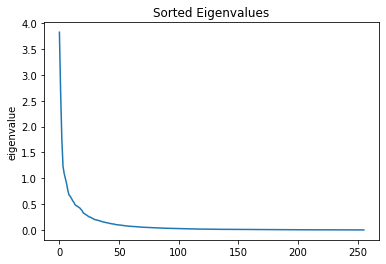

In [290]:
# apply PCA algorithm to the training data
k_values = [2, 5, 10, 20, 30]

mean = np.mean(inputs_train, axis=0)
centered = inputs_train - np.tile(mean, (inputs_train.shape[0], 1))

C = np.cov(centered.T)

U, S, V = np.linalg.svd(C)

plt.plot(S2)
plt.ylabel("eigenvalue")
plt.title("Sorted Eigenvalues")

k_spaces = []
for k in k_values:
    k_spaces.append(centered.dot(U[:,[i for i in range(k)]]))

In [163]:
# apply PCA to validation data
centered_valid = inputs_valid - np.tile(mean, (inputs_valid.shape[0], 1))

k_spaces_valid = []
for k in k_values:
    k_spaces_valid.append(centered_valid.dot(U[:,[i for i in range(k)]]))

In [164]:
def l2_distance(a, b):
    """Computes the Euclidean distance matrix between a and b.
    """

    if a.shape[0] != b.shape[0]:
        raise ValueError("A and B should be of same dimensionality")

    aa = np.sum(a**2, axis=0)
    bb = np.sum(b**2, axis=0)
    ab = np.dot(a.T, b)

    return np.sqrt(aa[:, np.newaxis] + bb[np.newaxis, :] - 2*ab)

In [165]:
def run_1nn(train_data, train_labels, valid_data):

    dist = l2_distance(valid_data.T, train_data.T)
    nearest = np.argsort(dist, axis=1)[:,:1]

    train_labels = train_labels.reshape(-1)
    valid_labels = train_labels[nearest]

    valid_labels = (np.mean(valid_labels, axis=1) >= 0.5).astype(np.int)
    valid_labels = valid_labels.reshape(-1,1)

    return valid_labels

## Question 3.a

Text(0, 0.5, 'misclassification rate')

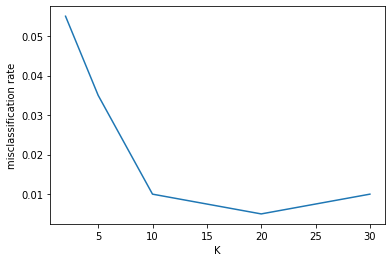

In [166]:
rates = []
for i in range(len(k_values)):
    prediction = run_1nn(k_spaces[i], target_train, k_spaces_valid[i])
    num_correct = np.sum(prediction == target_valid)
    rates.append((len(prediction) - num_correct)/len(prediction))
    
plt.plot(k_values, rates)
plt.xlabel('K')
plt.ylabel('misclassification rate')

## Question 3.b

I would choose K = 20 i.e. have 20 eigenvectors to model the data.
Having a K = 20 is still sufficiently smaller than D = 256, allowing us to have a good low-dimensional representation of the data.
From the misclassification rates seen from the validation set in 3.a, having 20 eigenvectors gave us the lowest misclassification rate of 0.005.

## Question 3.c

In [167]:
centered_test = inputs_test - np.tile(mean, (inputs_test.shape[0], 1))

k_space_test = centered_test.dot(U[:,[i for i in range(20)]])

test_prediction = run_1nn(k_spaces[-2], target_train, k_space_test)
num_correct = np.sum(test_prediction == target_test)

print("Misclassification rate of test data: ", (len(test_prediction) - num_correct) / len(test_prediction))

Misclassification rate of test data:  0.01


The performance of the final classifier over the test data performs fairly well with only a 0.01 misclassification rate. This value is close to the validation data's rate of 0.005 so it performs within expectations.